In [1]:
import numpy as np
import cupy as cp
import cuml
from cuml.decomposition import TruncatedSVD
from gensim.models import KeyedVectors
from scipy.stats import spearmanr
import csv
import pandas as pd
import gensim.downloader as api
import os

In [2]:
# Load the pre-trained FastText model
def load_fasttext_model():
    os.environ["GENSIM_DATA_DIR"] = "/teamspace/studios/pca/gensim-data"
    fasttext_model = api.load('fasttext-wiki-news-subwords-300')
    return fasttext_model
    
# Load SimLex-999 word similarity data
def load_simlex_999(file_path):
    """Loads SimLex-999 and returns word pairs with similarity scores."""
    data = []
    with open(file_path, 'r') as file:
        next(file)  # Skip header
        for line in file:
            parts = line.strip().split('\t')
            word1, word2, similarity_score = parts[0], parts[1], float(parts[3])
            data.append((word1, word2, similarity_score))
    return data

# Cosine similarity function for similarity evaluation
def cosine_similarity(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    return np.dot(v1, v2) / (norm1 * norm2)

# Evaluate embeddings on the word similarity data
def evaluate_embeddings(model, word_pairs):
    predicted_scores = []
    true_scores = []
    
    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1], model[word2])
            predicted_scores.append(sim_score)
            true_scores.append(true_score)
    
    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

# Task-driven dimensionality reduction using cuML's PCA with optimization for similarity
def task_driven_dimensionality_reduction(embeddings, target_dim=2, word_pairs=None, model=None):
    """Reduces dimensions while optimizing for similarity correlation and visualizes component removal impact."""
    
    # Convert numpy array to CuPy array for GPU processing
    cu_embeddings = cp.asarray(embeddings)
    
    # Initialize cuML PCA for dimensionality reduction
    # pca = cumlPCA(n_components=target_dim)
    svd = TruncatedSVD(n_components=target_dim, algorithm="full")
    reduced_embeddings = svd.fit_transform(cu_embeddings)
    
    # Convert back to numpy for further processing
    reduced_embeddings = cp.asnumpy(reduced_embeddings)
    
    # Create a reduced model to store optimized embeddings
    optimized_model = {word: reduced_embeddings[i] for i, word in enumerate(model.index_to_key)}
    
    # Evaluate initial Truncated SVD reduction
    initial_correlation = evaluate_embeddings(optimized_model, word_pairs)
    print(f"Initial Spearman Correlation after truncated svd to {target_dim}D: {initial_correlation:.4f}")
    
    # Initialize variables for tracking
    best_correlation = initial_correlation
    best_embeddings = reduced_embeddings
    correlations = [initial_correlation]  # Track correlations for each component removal count
    components_removed = [0]  # Track the number of components removed

    # Fine-tune  by adjusting top components
    for top_n in range(0, 299, 1):  # Try removing 0 to 298 top components
        # Re-apply PCA with additional top components
        svd_adjusted = TruncatedSVD(n_components=target_dim + top_n)
        expanded_embeddings = svd_adjusted.fit_transform(cu_embeddings)
        
        # Convert back to numpy
        expanded_embeddings = cp.asnumpy(expanded_embeddings)
        
        # Remove top components by zeroing them out to retain task-specific dimensions
        adjusted_embeddings = expanded_embeddings[:, top_n:]
        
        # Update the model with new adjusted embeddings
        adjusted_model = {word: adjusted_embeddings[i] for i, word in enumerate(model.index_to_key)}
        
        # Evaluate correlation on SimLex-999
        correlation = evaluate_embeddings(adjusted_model, word_pairs)
        print(f"Adjusted Correlation after removing top {top_n} components: {correlation:.4f}")
        
        # Append data for plotting
        correlations.append(correlation)
        components_removed.append(top_n)
        
        # Track the best adjustment that maximizes the Spearman correlation
        if correlation > best_correlation:
            best_correlation = correlation
            best_embeddings = adjusted_embeddings
    
    print(f"Best Spearman Correlation with Task-Driven Reduction: {best_correlation:.4f}")
    
    return best_embeddings, best_correlation    

In [3]:
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'  # Update this path to your SimLex-999 file
target_dim = 2  # Adjust target_dim as needed for testing (e.g., 150, 100, 50)

In [4]:
print("Loading FastText model...")
original_model = load_fasttext_model()

Loading FastText model...


In [5]:
word_pairs = load_simlex_999(simlex_file_path)

In [6]:
# Perform task-driven dimensionality reduction
optimized_embeddings, best_correlation = task_driven_dimensionality_reduction(
    original_model.vectors, 
    target_dim=target_dim, 
    word_pairs=word_pairs, 
    model=original_model
)

print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")

Initial Spearman Correlation after PCA to 2D: 0.0844
Adjusted Correlation after removing top 0 components: 0.0844
Adjusted Correlation after removing top 1 components: 0.0644
Adjusted Correlation after removing top 2 components: 0.0487
Adjusted Correlation after removing top 3 components: 0.0486
Adjusted Correlation after removing top 4 components: 0.0639
Adjusted Correlation after removing top 5 components: 0.1008
Adjusted Correlation after removing top 6 components: 0.1598
Adjusted Correlation after removing top 7 components: 0.1745
Adjusted Correlation after removing top 8 components: 0.1512
Adjusted Correlation after removing top 9 components: 0.1470
Adjusted Correlation after removing top 10 components: 0.0874
Adjusted Correlation after removing top 11 components: 0.0502
Adjusted Correlation after removing top 12 components: 0.0657
Adjusted Correlation after removing top 13 components: 0.0376
Adjusted Correlation after removing top 14 components: 0.0339
Adjusted Correlation after 

In [7]:
# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [8]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
file_path="TruncatedSVD_FastText_2d_word_embeddings.csv"
# Save the embeddings and words to a CSV file
save_embeddings_to_csv(words, optimized_embeddings, file_path)

Saving 2D embeddings to TruncatedSVD_FastText_2d_word_embeddings.csv...
2D embeddings saved successfully.


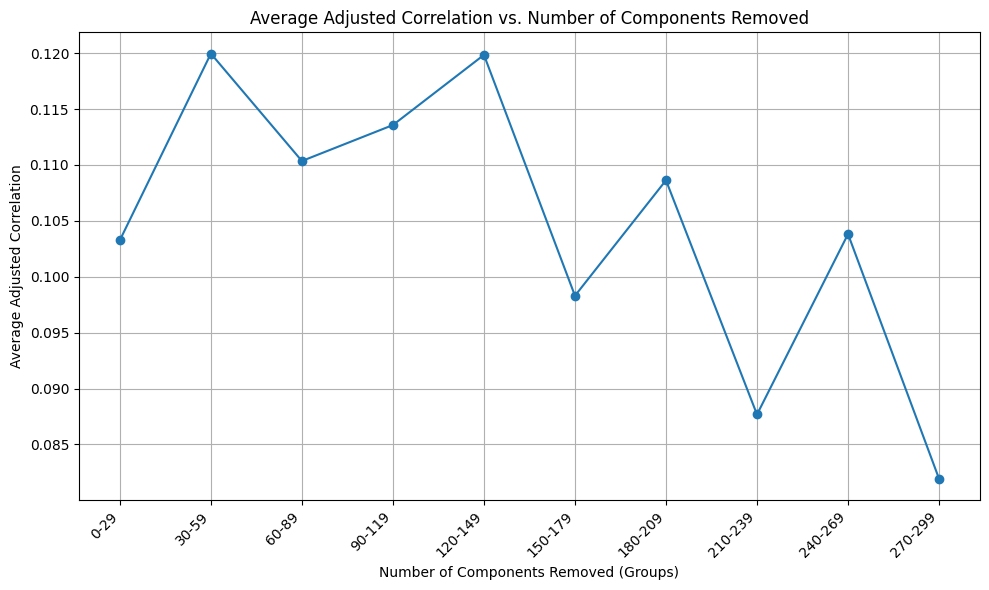

In [1]:
import matplotlib.pyplot as plt
import re

def extract_and_plot_data(filepath):
    """
    Extracts data from a text file, groups it, calculates averages, and plots the results.

    Args:
        filepath: The path to the text file.
    """

    correlations = []
    with open(filepath, 'r') as f:
        for line in f:
            match = re.search(r"Adjusted Correlation after removing top (\d+) components: (-?\d+\.\d+)", line)
            if match:
                num_components = int(match.group(1))
                correlation = float(match.group(2))
                correlations.append((num_components, correlation))

    # Group data and calculate averages
    group_averages = []
    group_labels = []
    for i in range(0, 300, 30):  # Changed step size from 50 to 30
        group = [corr for comp, corr in correlations if i <= comp < i + 30]  # Changed range from 50 to 30
        if group:  # Check if the group is not empty
            average_correlation = sum(group) / len(group)
            group_averages.append(average_correlation)
            group_labels.append(f"{i}-{min(i + 29, 299)}")  # Changed from i + 49 to i + 29

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(group_labels, group_averages, marker='o', linestyle='-')
    plt.xlabel("Number of Components Removed (Groups)")
    plt.ylabel("Average Adjusted Correlation")
    plt.title("Average Adjusted Correlation vs. Number of Components Removed")
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Example usage:
filepath = '/teamspace/studios/this_studio/TRUNCATED SVD/TruncatedSVD_FastText_data.txt'  # Replace with your file path
extract_and_plot_data(filepath)

[0.10326666666666666, 0.11995666666666664, 0.11034999999999999, 0.11356666666666664, 0.11983999999999999, 0.09830000000000001, 0.10862666666666668, 0.08768, 0.10381333333333333, 0.08193448275862068]
[0.06550333333333333, 0.06730666666666665, 0.08476666666666664, 0.08780333333333333, 0.11688000000000001, 0.10347, 0.11521666666666666, 0.07126666666666666, 0.03280333333333333, -0.009348275862068968]
[0.07160333333333332, 0.09807333333333332, 0.10523999999999999, 0.11682999999999999, 0.1016766666666667, 0.10884666666666666, 0.11390999999999998, 0.10794333333333331, 0.10920666666666666, 0.12808275862068963]


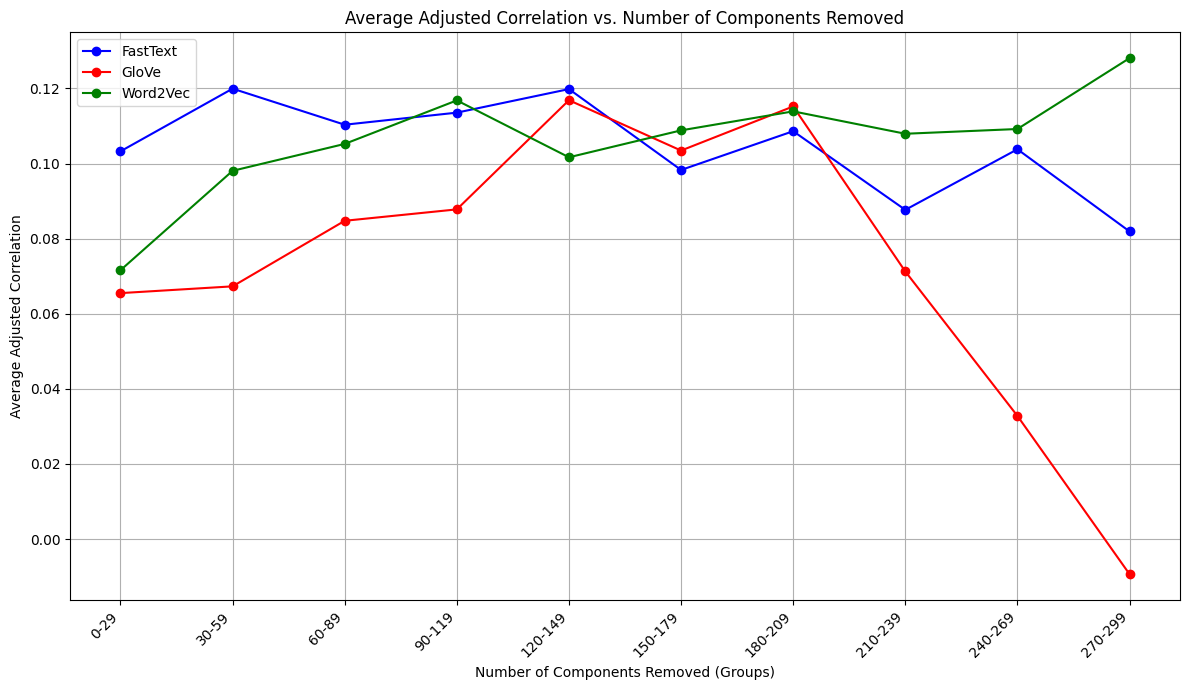

In [1]:
import matplotlib.pyplot as plt
import re

def extract_data(filepath):
    """
    Extracts data from a text file and returns the correlations.

    Args:
        filepath: The path to the text file.
    
    Returns:
        A list of tuples containing (num_components, correlation).
    """
    correlations = []
    with open(filepath, 'r') as f:
        for line in f:
            match = re.search(r"Adjusted Correlation after removing top (\d+) components: (-?\d+\.\d+)", line)
            if match:
                num_components = int(match.group(1))
                correlation = float(match.group(2))
                correlations.append((num_components, correlation))
    return correlations

def calculate_group_averages(correlations):
    """
    Groups data and calculates averages.
    
    Args:
        correlations: A list of tuples containing (num_components, correlation).
    
    Returns:
        Two lists: group_labels and group_averages.
    """
    group_averages = []
    group_labels = []
    for i in range(0, 300, 30):  # Step size of 30
        group = [corr for comp, corr in correlations if i <= comp < i + 30]
        if group:  # Check if the group is not empty
            average_correlation = sum(group) / len(group)
            group_averages.append(average_correlation)
            group_labels.append(f"{i}-{min(i + 29, 299)}")
    
    return group_labels, group_averages

def plot_multiple_models(filepaths, model_names, colors):
    """
    Extracts data from multiple files, calculates averages, and plots the results with different colors.

    Args:
        filepaths: A list of paths to the text files.
        model_names: A list of model names for the legend.
        colors: A list of colors for the lines.
    """
    plt.figure(figsize=(12, 7))
    
    for filepath, model_name, color in zip(filepaths, model_names, colors):
        correlations = extract_data(filepath)
        group_labels, group_averages = calculate_group_averages(correlations)
        
        plt.plot(group_labels, group_averages, marker='o', linestyle='-', color=color, label=model_name)
        print(group_averages)
    
    plt.xlabel("Number of Components Removed (Groups)")
    plt.ylabel("Average Adjusted Correlation")
    plt.title("Average Adjusted Correlation vs. Number of Components Removed")
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.legend(loc='best')  # Add legend
    plt.tight_layout()
    plt.show()

# Example usage:
filepaths = [
    '/teamspace/studios/this_studio/TRUNCATED SVD/TruncatedSVD_FastText_data.txt',
    '/teamspace/studios/this_studio/TRUNCATED SVD/TruncatedSVD_Glove_data.txt',
    '/teamspace/studios/this_studio/TRUNCATED SVD/TruncatedSVD_Word2Vec_data.txt'
]
model_names = ['FastText', 'GloVe', 'Word2Vec']
colors = ['blue', 'red', 'green']  # Different colors for each model

plot_multiple_models(filepaths, model_names, colors)